<h1><center>Rossmann Store Sales</center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime
from datetime import timedelta, date
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as rmse
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

### Data fields

<ul style="font-size:16px;">
    <li>Id - an Id that represents a (Store, Date) duple within the test set   
    <br><br>
    <li>Store - a unique Id for each store
    <br><br>
    <li>Sales - the turnover for any given day (this is what you are predicting)
    <br><br>
    <li>Customers - the number of customers on a given day
    <br><br>
    <li>Open - an indicator for whether the store was open: 0 = closed, 1 = open
    <br><br>
    <li>StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    <br><br>
    <li>SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    <br><br>
    <li>StoreType - differentiates between 4 different store models: a, b, c, d
    <br><br>
    <li>Assortment - describes an assortment level: a = basic, b = extra, c = extended
    <br><br>
    <li>CompetitionDistance - distance in meters to the nearest competitor store
    <br><br>
    <li>CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    <br><br>
    <li>Promo - indicates whether a store is running a promo on that day
    <br><br>
    <li>Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    <br><br>
    <li>Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    <br><br>
    <li>PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
</ul>

In [2]:
train=pd.read_csv("data/train.csv")
store=pd.read_csv("data/store.csv")
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
print(train.info(),'\n')
print(store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceW

In [5]:
# Remove duplicate entries
train=train.drop_duplicates()
store=store.drop_duplicates()
print(train.shape)
print(store.shape)

(1017209, 9)
(1115, 10)


In [6]:
temp=train.groupby(['Store'],as_index=False).agg({'Date':'nunique'})
temp[(temp['Date']<942)]

,Store,Date
12,13,758
19,20,758
21,22,758
31,32,758
35,36,758
...,...,...
1093,1094,758
1101,1102,758
1103,1104,758
1106,1107,758


In [7]:
temp[(temp['Date']!=758)&(temp['Date']!=942)]

,Store,Date
987,988,941


In [8]:
# Create a list of store with missing rows
missing_list=temp[(temp['Date']==758)]['Store'].to_list()

In [9]:
temp=train[train['Store']==1109]
temp.index=pd.to_datetime(temp['Date'])
temp[temp['Store']==1109]['2015-01-01':'2014-06-30']

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,,
2015-01-01,1109,4,2015-01-01,0,0,0,0,a,1
2014-06-30,1109,1,2014-06-30,7181,558,1,1,0,0


Data of 181 stores is missing from 01-07-2014 to 31-12-2014

In [10]:
train.index=train['Date']
train[train['Store']==988]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,,
2015-07-31,988,5,2015-07-31,5494,724,1,1,0,1
2015-07-30,988,4,2015-07-30,4591,673,1,1,0,1
2015-07-29,988,3,2015-07-29,4522,689,1,1,0,1
2015-07-28,988,2,2015-07-28,4592,705,1,1,0,1
2015-07-27,988,1,2015-07-27,6011,812,1,1,0,1
...,...,...,...,...,...,...,...,...,...
2013-01-06,988,7,2013-01-06,0,0,0,0,0,0
2013-01-05,988,6,2013-01-05,3849,590,1,0,0,0
2013-01-04,988,5,2013-01-04,3940,646,1,0,0,1


Data of store number 988 is missing for 01-01-2013

In [11]:
# Sort train data by date and store
train.reset_index(inplace=True,drop=True)
train.sort_values(by=['Date','Store'],inplace=True)
train.index=train.Date

In [12]:
# Generate rows for missing data
missing=pd.DataFrame()
for i in missing_list:
    current=pd.DataFrame({'Date': pd.date_range('2014-07-01','2014-12-31', freq='D'), 'Store': i})
    # School and state holidays are taken from entries of store 1
    current['StateHoliday']=train[train['Store']==1]['2014-07-01':'2014-12-31']['StateHoliday'].to_list()
    current['SchoolHoliday']=train[train['Store']==1]['2014-07-01':'2014-12-31']['SchoolHoliday'].to_list()
    missing=pd.concat([missing,current],ignore_index=True)
missing=pd.concat([missing,pd.DataFrame({'Date': pd.date_range('2013-01-01','2013-01-01', freq='D'), 'Store': 988,'StateHoliday':'a','SchoolHoliday':1})],ignore_index=True)
missing.index=missing.Date
missing.drop(['Date'],inplace=True,axis=1)
missing['DayOfWeek']=missing.index.weekday+1
missing.reset_index(inplace=True)

In [13]:
# Insert missing rows
train.reset_index(drop=True,inplace=True)
train['Date']=pd.to_datetime(train['Date'])
train=pd.merge(train,missing,on=['Store','Date','DayOfWeek','StateHoliday','SchoolHoliday'],how='outer')

In [14]:
train.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales             True
Customers         True
Open              True
Promo             True
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [15]:
# Stores with missing data may have been closed for refurbishment
# Set sales, Customers, Open, Promo as 0 for missing data 
train.fillna(0,inplace=True)

In [16]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [17]:
store.CompetitionDistance.describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [18]:
# Fill NaN values for Competition distance with median value
store.CompetitionDistance.fillna(store.CompetitionDistance.median(),inplace=True)

In [19]:
# Flag the missing values with 0
store.CompetitionOpenSinceMonth.fillna(0,inplace=True)
store.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [20]:
store[(store['Promo2']==1) & (store['Promo2SinceWeek'].isnull())]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [21]:
# Since there is no promo2 information about it is missing
# It can be replaced by 0
store.fillna(0,inplace=True)

In [22]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


In [23]:
# Combine sales data and store info
df=pd.merge(train,store,how='inner',on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,2013-01-01,0.0,0.0,0.0,0.0,a,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,3,2013-01-02,5530.0,668.0,1.0,0.0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,4,2013-01-03,4327.0,578.0,1.0,0.0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,5,2013-01-04,4486.0,619.0,1.0,0.0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,6,2013-01-05,4997.0,635.0,1.0,0.0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


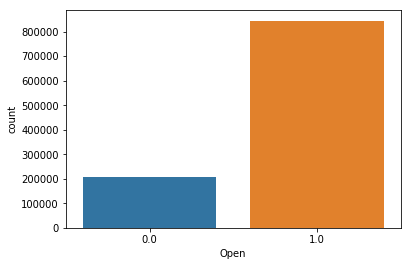

In [24]:
sns.countplot(df.Open);

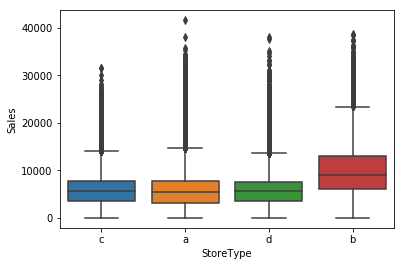

In [25]:
sns.boxplot(y='Sales',x='StoreType',data=df);

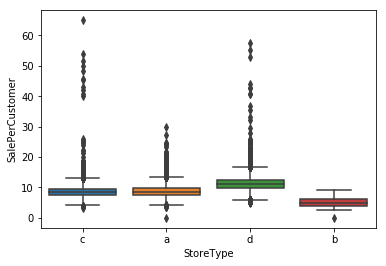

In [26]:
df['SalePerCustomer']=df.Sales/df.Customers
sns.boxplot(y='SalePerCustomer',x='StoreType',data=df);

Store type b has highest sales but lowest average sales per customer.

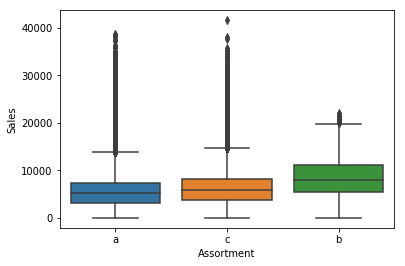

In [27]:
sns.boxplot(y='Sales',x='Assortment',data=df);

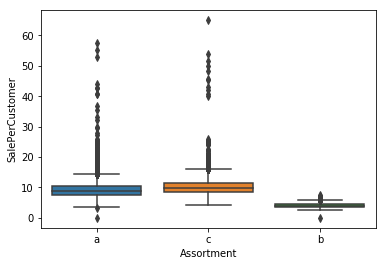

In [28]:
sns.boxplot(y='SalePerCustomer',x='Assortment',data=df);

Stores with assortment level 'extra' have higher median sales but low sales per customer than other stores.

In [29]:
# Convert State holiday 0 to string
df.StateHoliday=df.StateHoliday.apply(lambda x:str(x))

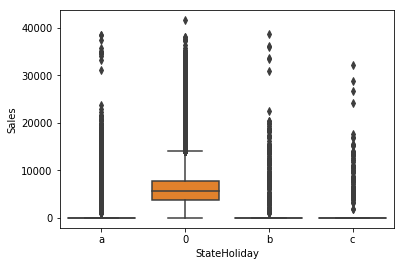

In [30]:
sns.boxplot(y='Sales',x='StateHoliday',data=df);

Sales are very low on state holidays

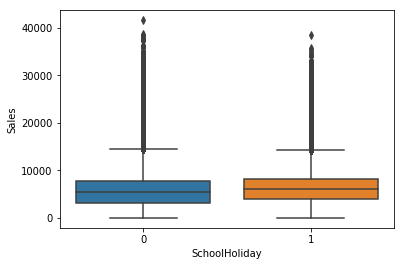

In [31]:
sns.boxplot(y='Sales',x='SchoolHoliday',data=df);

Sales on school holidays are slightly more

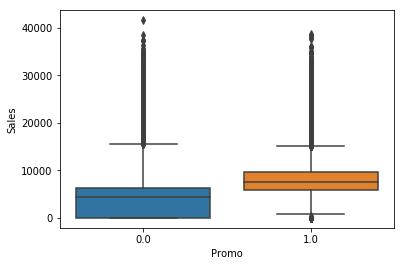

In [32]:
sns.boxplot(y='Sales',x='Promo',data=df);

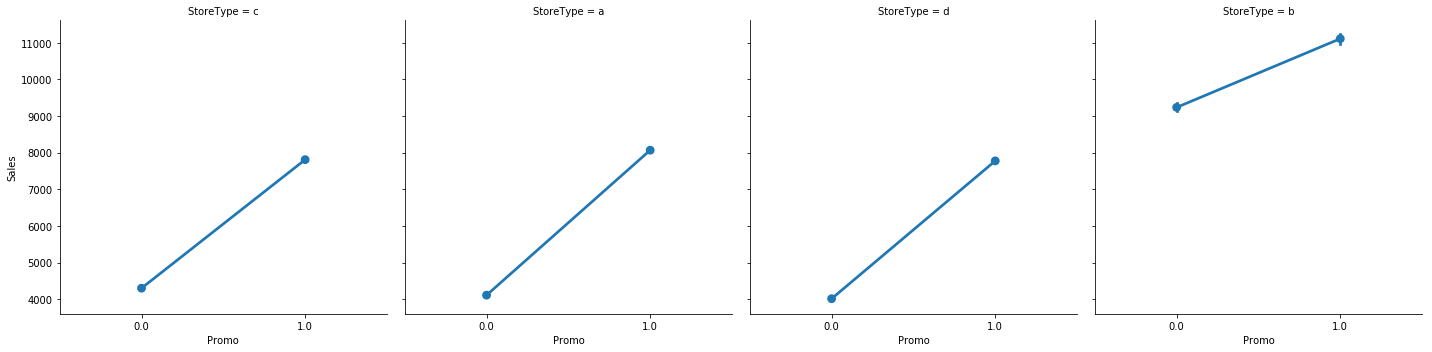

In [33]:
sns.catplot(data=df,x='Promo',y='Sales',col='StoreType',kind="point");

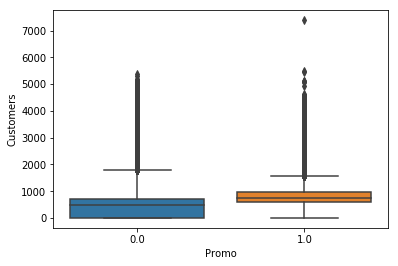

In [34]:
sns.boxplot(y='Customers',x='Promo',data=df);

Running a promo increases sales and number of customers significantly. The increase is less in store type b.

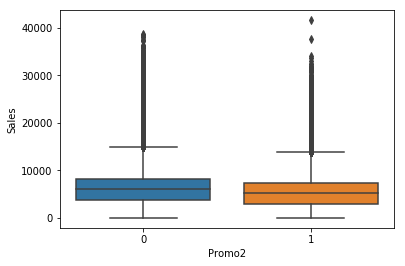

In [35]:
sns.boxplot(y='Sales',x='Promo2',data=df);

Stores participating in continuing and consecutive promotion have slightly lower sales than stores not participating

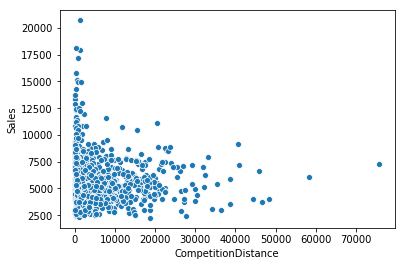

In [36]:
sns.scatterplot(y='Sales',x='CompetitionDistance',data=df[~(df.CompetitionDistance==0)].groupby(['Store']).agg({'CompetitionDistance':'mean','Sales':'mean'}));

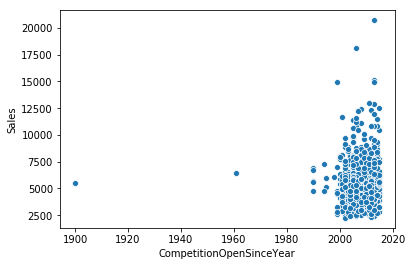

In [37]:
sns.scatterplot(y='Sales',x='CompetitionOpenSinceYear',data=df[~(df.CompetitionOpenSinceYear==0)].groupby(['Store']).agg({'CompetitionOpenSinceYear':'mean','Sales':'mean'}));

In [38]:
df['Date']=pd.to_datetime(df['Date'])
df['Month']=df.Date.dt.month
df['Year']=df.Date.dt.year
df.index=df.Date
df.drop(['Date'],inplace=True,axis=1)
df = df.sort_index()

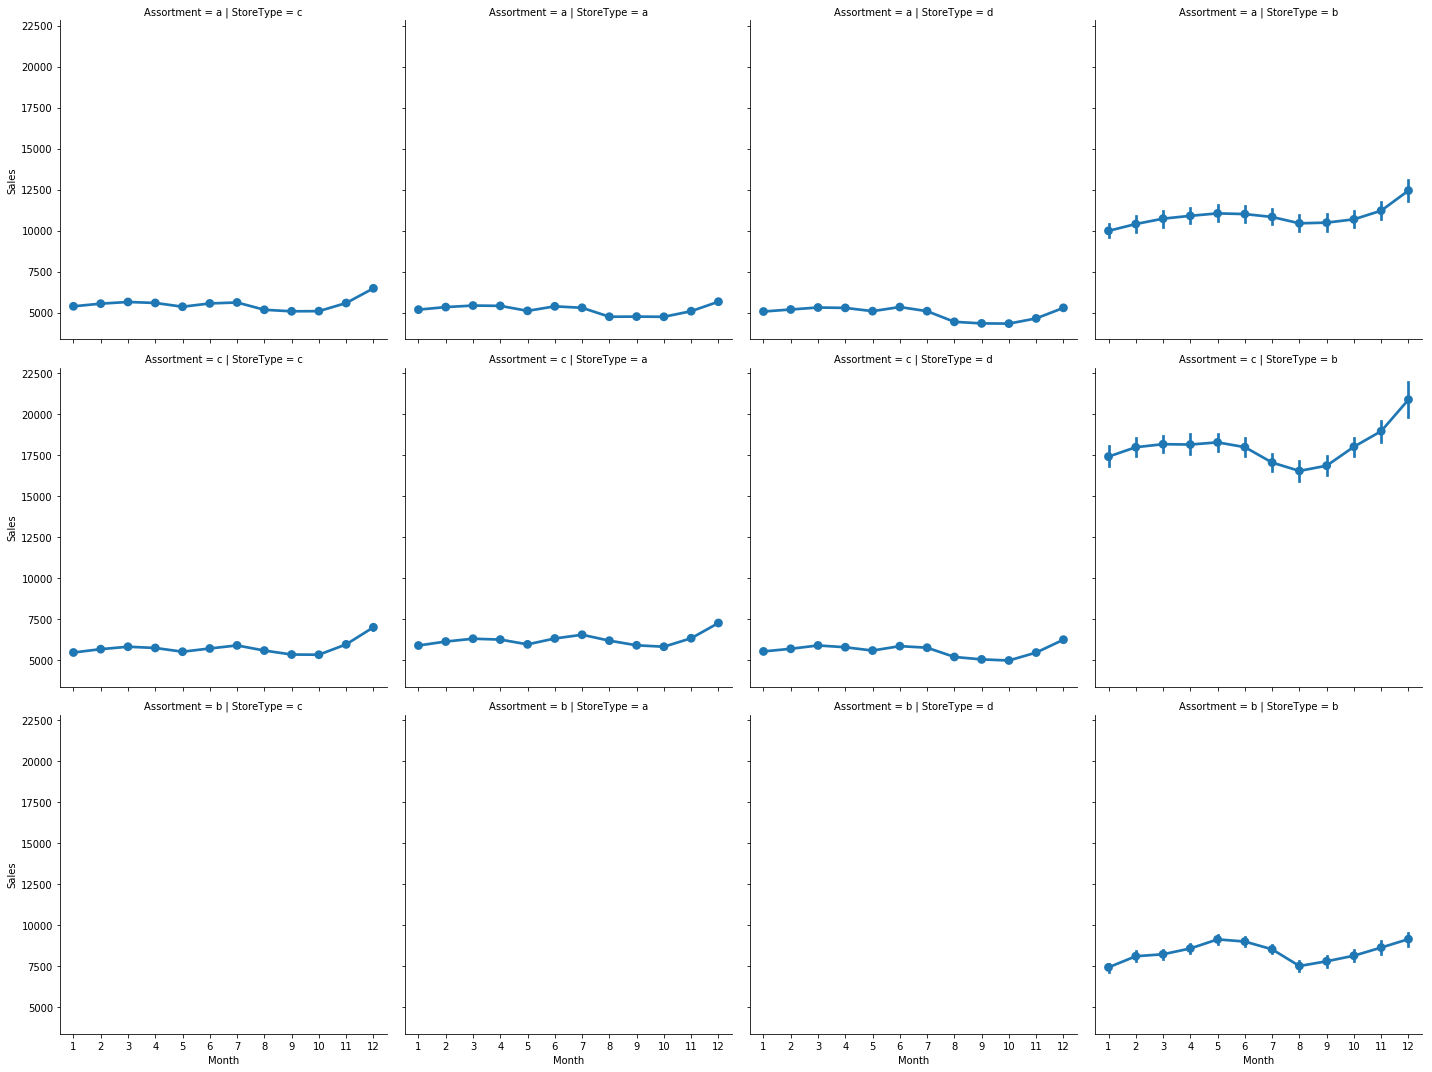

In [39]:
sns.catplot(data=df,x='Month',y='Sales',col='StoreType',row='Assortment',kind='point');

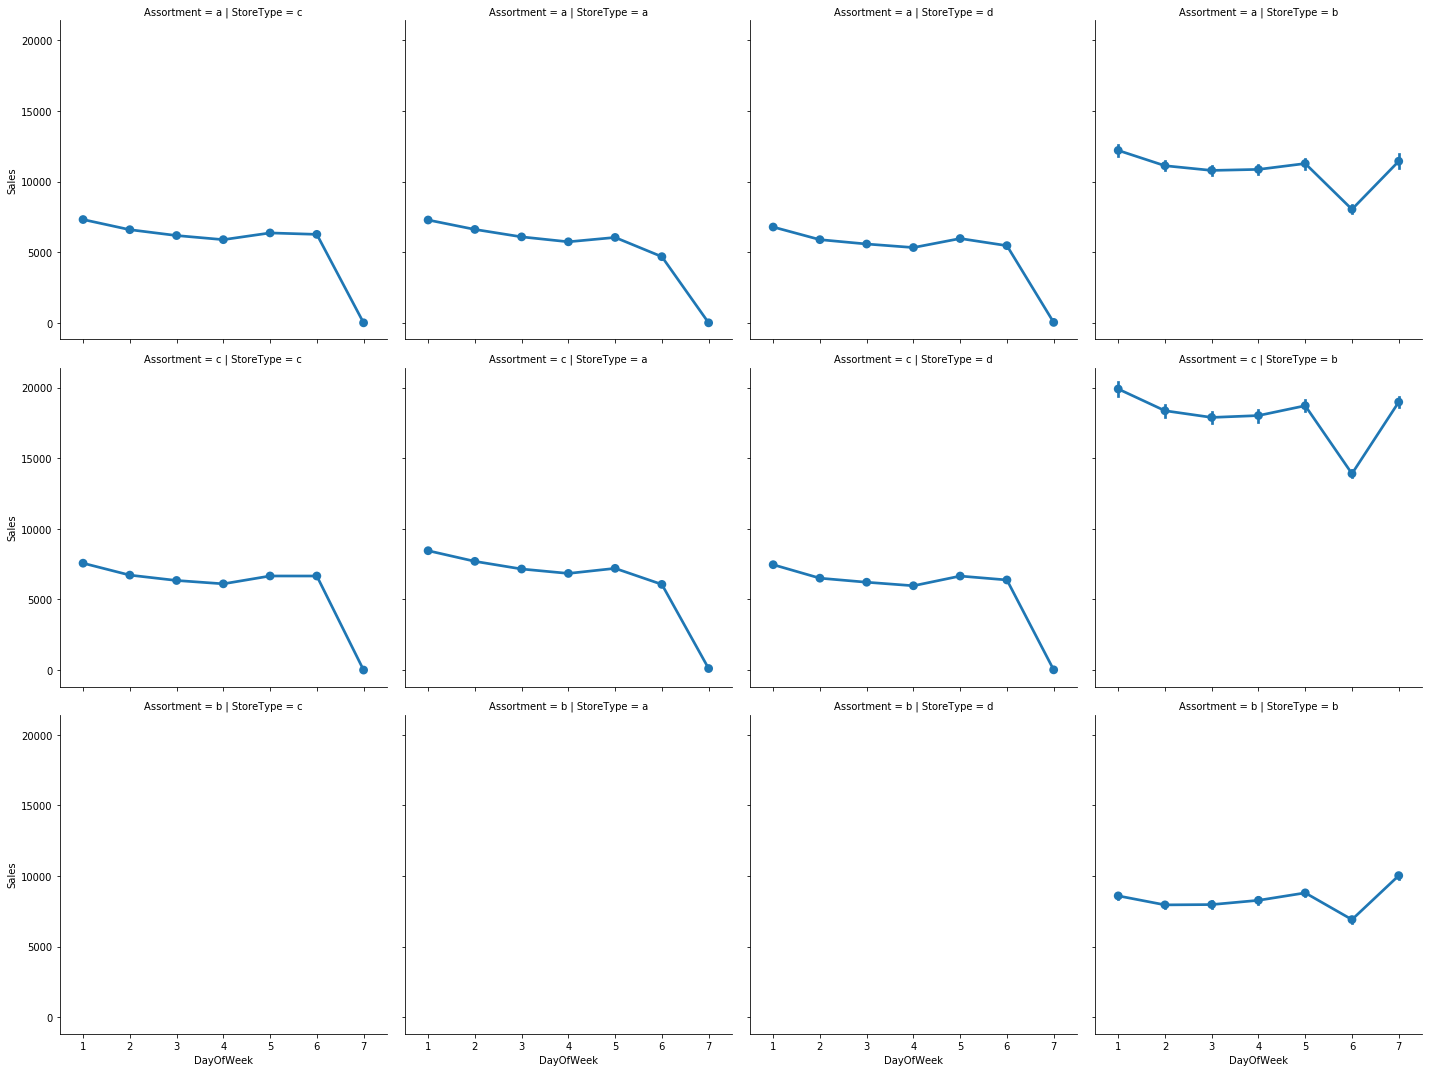

In [40]:
sns.catplot(data=df,x='DayOfWeek',y='Sales',col='StoreType',row='Assortment',kind='point');

Store types a,c and d have similar sales pattern

In [41]:
# Function to get exogenous variables for ARIMAX
def get_exog(store,df):
    exog=df[df['Store']==store].loc[:,['Open','Promo','StateHoliday','SchoolHoliday']]
    
    # month one hot encoding
    exog['month'] = exog.index.month
    month_dummies=pd.DataFrame(columns = ['month-'+ str(m) for m in range(1,13)])
    for m in range(1,13):
        month_dummies['month-'+str(m)] = exog['month'].apply(lambda x:int((x==m)))
    exog = pd.concat([exog, month_dummies], axis=1, ).drop(['month'],axis=1)
    
    # dayofweek one hot encoding
    exog['dayofweek'] = exog.index.weekday
    week_dummies = pd.get_dummies(exog['dayofweek'])
    week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
    exog = pd.concat([exog, week_dummies], axis=1).drop(['dayofweek'],axis=1)
    
    exog['StateHoliday']=(exog['StateHoliday']!='0').astype(int)
    
    return exog

In [42]:
sales_a=df[df['Store']==2]['Sales'].squeeze()
sales_b=df[df['Store']==259]['Sales'].squeeze()
sales_c=df[df['Store']==1]['Sales'].squeeze()
sales_d=df[df['Store']==1115]['Sales'].squeeze()

In [43]:
train_start,train_end = '2013-01-01','2015-04-30'
test_start,test_end = '2015-05-01','2015-07-31'

In [44]:
# Function to check stationarity using Augmented Dickey-Fuller Test
def stationary_check(sales):
    result = adfuller(sales)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
       print(key, value)
    print()

In [45]:
# Function to display ACF and PACF plots
def auto_corr(sales):
    _,axes=plt.subplots(ncols=2,figsize=(14,4))
    plot_acf(sales,lags=50,ax=axes[0])
    plot_pacf(sales,lags=50,ax=axes[1])

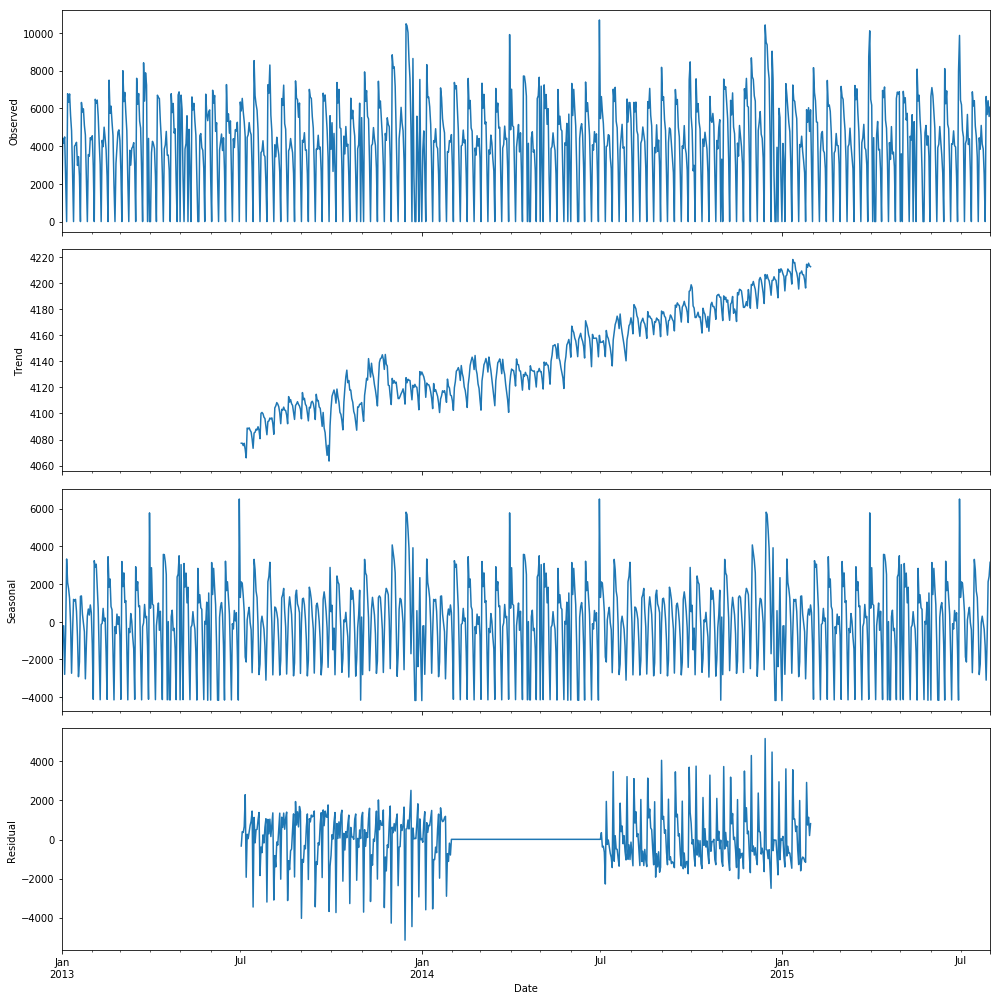

In [46]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,14))
    seasonal_decompose(sales_a, model = 'additive', freq = 365).plot();

In [47]:
stationary_check(sales_a)

ADF Statistic: -6.369024
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583



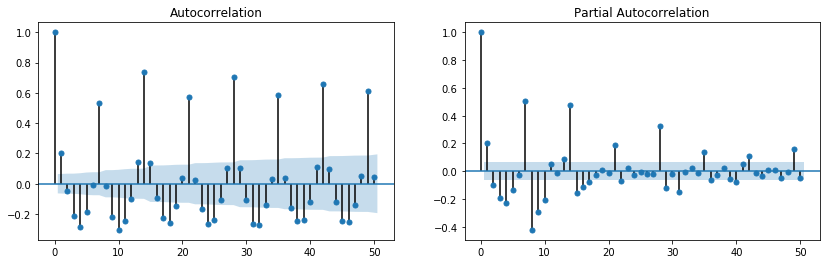

In [48]:
auto_corr(sales_a)

In [49]:
model = sm.tsa.statespace.SARIMAX(sales_a[train_start:train_end], order=(5,0,5),seasonal_order=(1,0,1,12),exog=get_exog(2,df)[train_start:train_end],freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  850
Model:             SARIMAX(5, 0, 5)x(1, 0, 1, 12)   Log Likelihood               -6732.301
Date:                            Wed, 22 Jan 2020   AIC                          13536.602
Time:                                    13:20:10   BIC                          13707.430
Sample:                                01-01-2013   HQIC                         13602.038
                                     - 04-30-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           3319.6843    451.940      7.345      0.000    2433.898    4205.470
Promo          1948.6591  

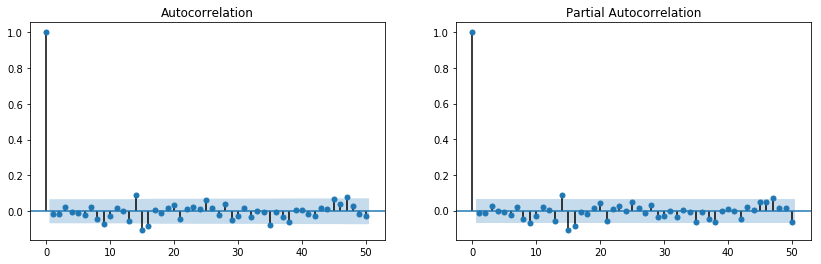

In [50]:
auto_corr(model_fit.resid)

In [51]:
rmse(sales_a[test_start:test_end],model_fit.predict(test_start,test_end,exog=get_exog(2,df)[test_start:test_end]))

439524.92361901375

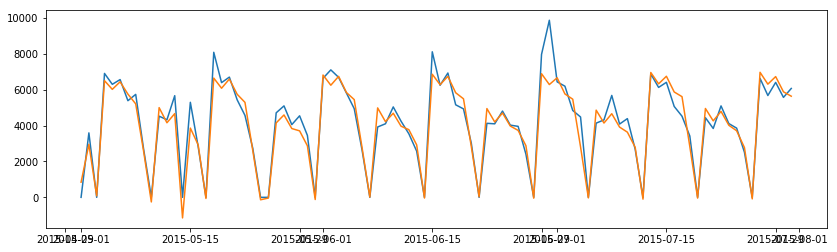

In [52]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    plt.plot(sales_a[test_start:test_end])
    plt.plot(model_fit.predict(test_start,test_end,exog=get_exog(2,df)[test_start:test_end]))

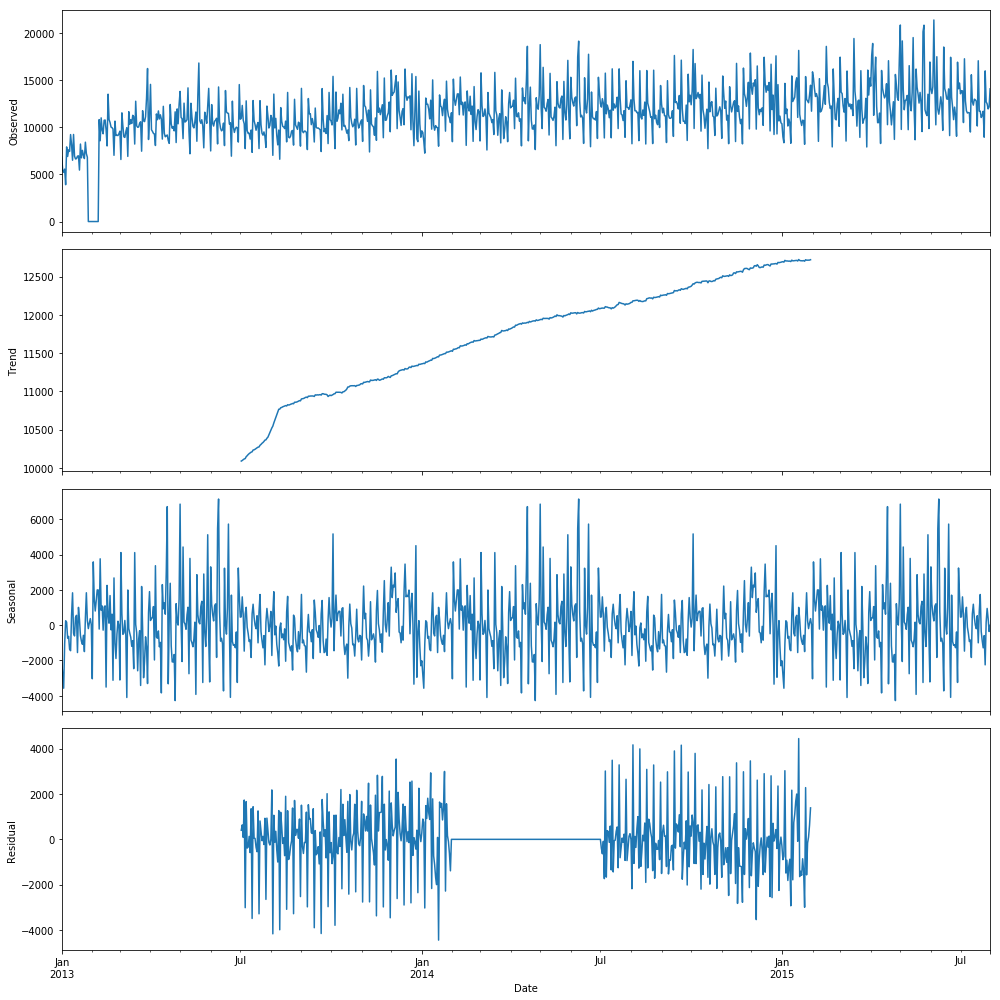

In [53]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,14))
    seasonal_decompose(sales_b, model = 'additive', freq = 365).plot();

In [54]:
stationary_check(sales_b)

ADF Statistic: -3.429155
p-value: 0.010004
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583



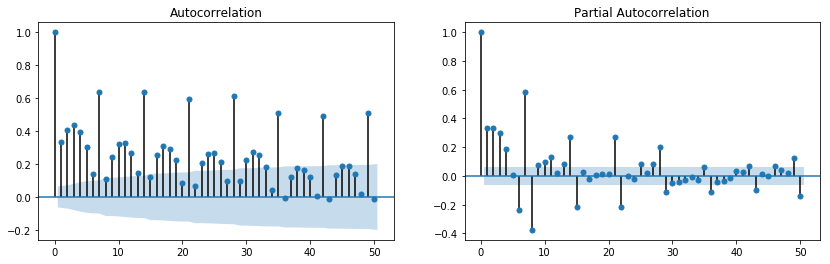

In [55]:
auto_corr(sales_b)

In [56]:
model = sm.tsa.statespace.SARIMAX(sales_b[train_start:train_end], order=(5,0,5),seasonal_order=(1,0,1,7),exog=get_exog(259,df)[train_start:train_end],freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  850
Model:             SARIMAX(5, 0, 5)x(1, 0, 1, 7)   Log Likelihood               -7089.338
Date:                           Wed, 22 Jan 2020   AIC                          14250.677
Time:                                   13:20:40   BIC                          14421.505
Sample:                               01-01-2013   HQIC                         14316.113
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           1.096e+04    300.754     36.442      0.000    1.04e+04    1.15e+04
Promo          1290.7124    175.43

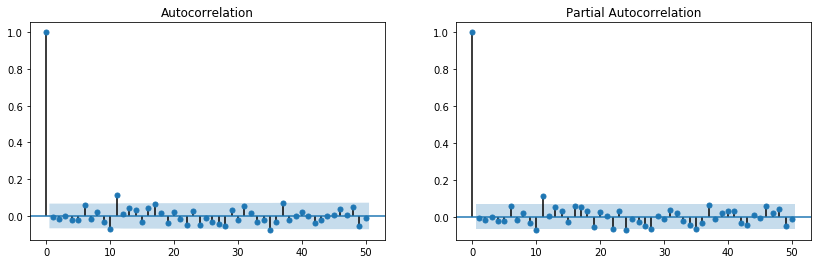

In [57]:
auto_corr(model_fit.resid)

In [58]:
rmse(sales_b[test_start:test_end],model_fit.predict(test_start,test_end,exog=get_exog(2,df)[test_start:test_end]))

28356531.45412999

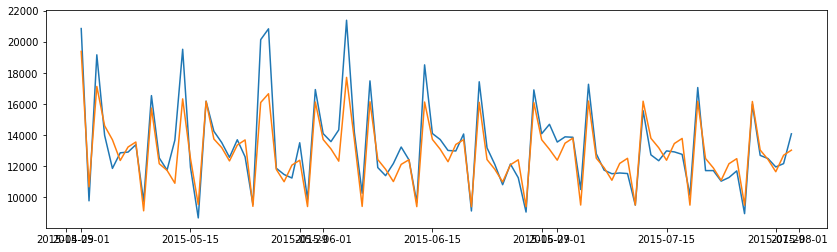

In [59]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    plt.plot(sales_b[test_start:test_end])
    plt.plot(model_fit.predict(test_start,test_end,exog=get_exog(259,df)[test_start:test_end]))

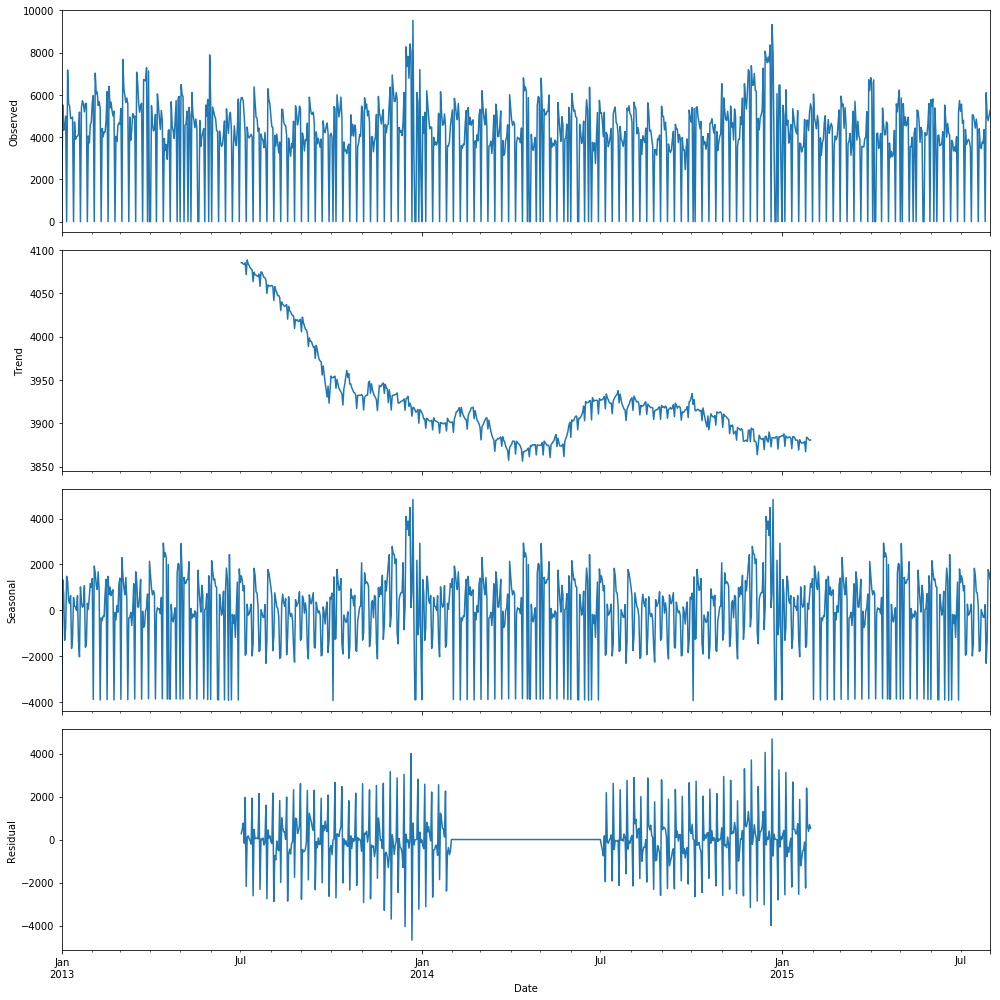

In [60]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,14))
    seasonal_decompose(sales_c, model = 'additive', freq = 365).plot();

In [61]:
stationary_check(sales_c)

ADF Statistic: -4.368104
p-value: 0.000338
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583



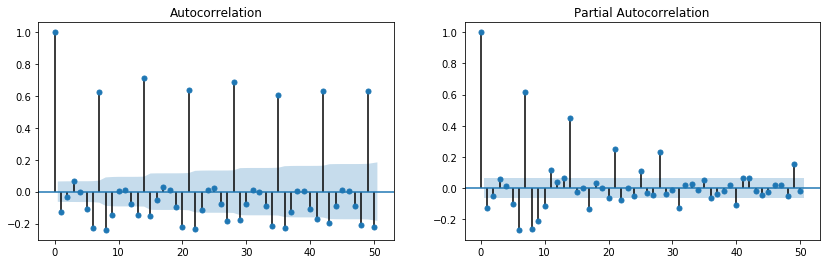

In [62]:
auto_corr(sales_c)

In [63]:
model = sm.tsa.statespace.SARIMAX(sales_c[train_start:train_end], order=(4,0,3),seasonal_order=(2,0,2,7),exog=get_exog(1,df)[train_start:train_end],freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  850
Model:             SARIMAX(4, 0, 3)x(2, 0, 2, 7)   Log Likelihood               -6626.397
Date:                           Wed, 22 Jan 2020   AIC                          13322.795
Time:                                   13:21:20   BIC                          13488.878
Sample:                               01-01-2013   HQIC                         13386.413
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           3598.1427     48.631     73.988      0.000    3502.827    3693.458
Promo          1247.6374     64.97

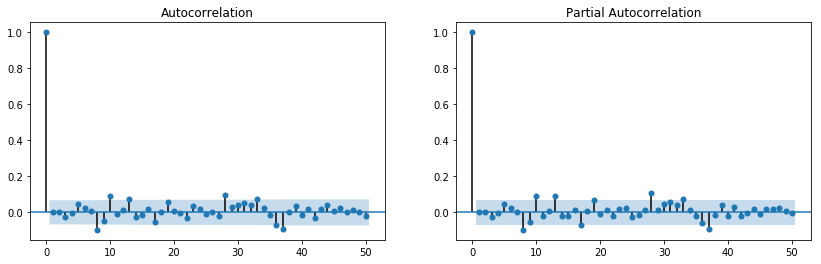

In [64]:
auto_corr(model_fit.resid)

In [65]:
rmse(sales_c[test_start:test_end],model_fit.predict(test_start,test_end,exog=get_exog(1,df)[test_start:test_end]))

237322.81537585342

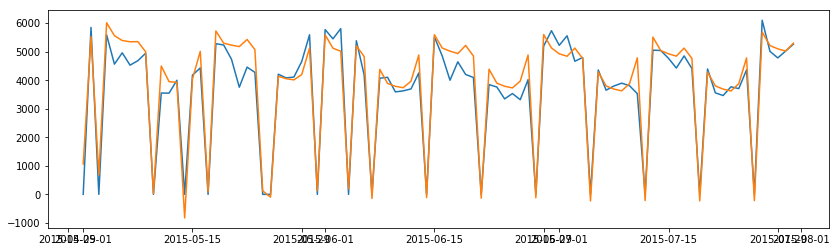

In [66]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    plt.plot(sales_c[test_start:test_end])
    plt.plot(model_fit.predict(test_start,test_end,exog=get_exog(1,df)[test_start:test_end]))

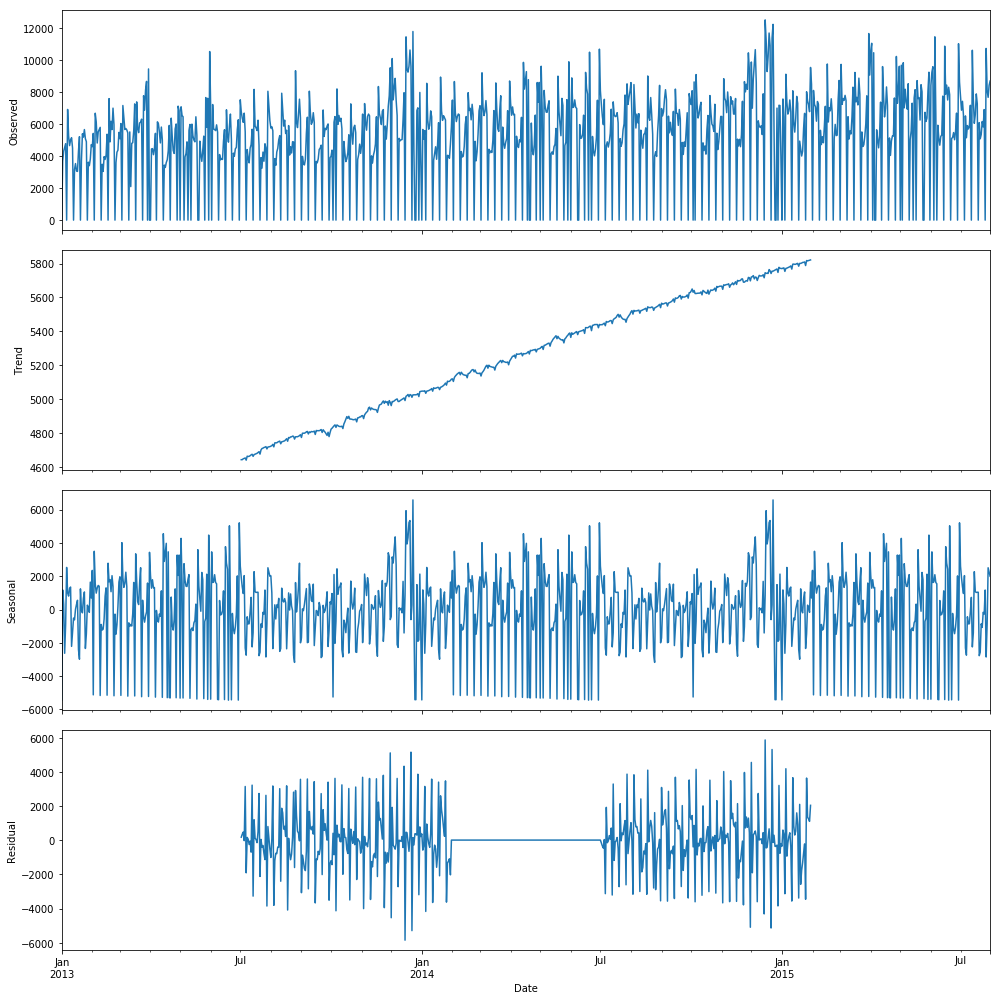

In [67]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,14))
    seasonal_decompose(sales_d, model = 'additive', freq = 365).plot();

In [68]:
stationary_check(sales_d)

ADF Statistic: -3.599970
p-value: 0.005762
Critical Values:
1% -3.437470108019385
5% -2.8646832620852853
10% -2.5684436698650503



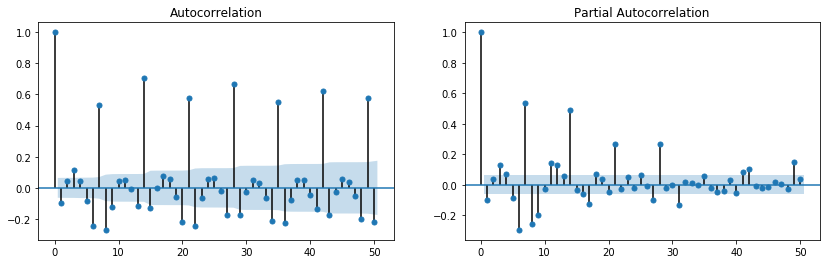

In [69]:
auto_corr(sales_d)

In [70]:
model = sm.tsa.statespace.SARIMAX(sales_d[train_start:train_end], order=(4,0,4),seasonal_order=(3,0,3,7),exog=get_exog(1115,df)[train_start:train_end],freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  850
Model:             SARIMAX(4, 0, 4)x(3, 0, 3, 7)   Log Likelihood               -6986.525
Date:                           Wed, 22 Jan 2020   AIC                          14049.049
Time:                                   13:22:45   BIC                          14229.368
Sample:                               01-01-2013   HQIC                         14118.121
                                    - 04-30-2015                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           4456.9199    195.697     22.775      0.000    4073.361    4840.479
Promo          2248.0451    118.67

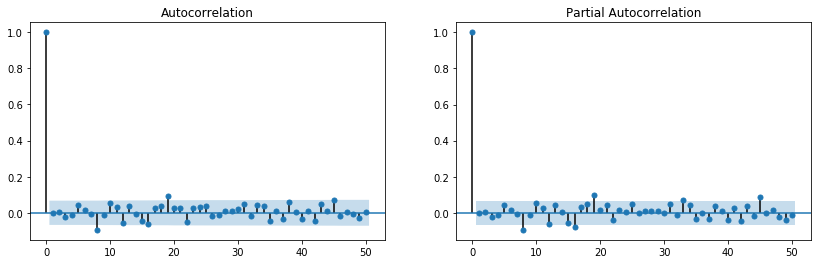

In [71]:
auto_corr(model_fit.resid)

In [72]:
rmse(sales_d[test_start:test_end],model_fit.predict(test_start,test_end,exog=get_exog(1115,df)[test_start:test_end]))

1296400.1387284398

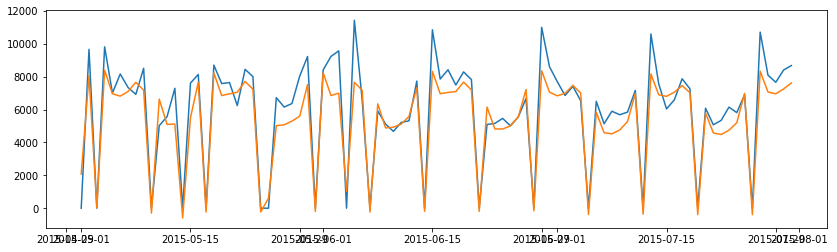

In [73]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    plt.plot(sales_d[test_start:test_end])
    plt.plot(model_fit.predict(test_start,test_end,exog=get_exog(1115,df)[test_start:test_end]))

SARIMAX model has good prediction but it will take too much time to train for 1115 stores

In [74]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [75]:
# Function to preprocess data
def preprocess(df):
    exog=df.copy()
    exog['month'] = exog.index.month
    exog['dayofweek'] = exog.index.weekday
    exog['weekofyear'] = exog.index.weekofyear
    exog['StateHoliday']=(exog['StateHoliday']!='0').astype(int)

    # Store type one hot encoding
    storetype_dummies=pd.DataFrame(columns = ['storetype-'+ w for w in exog['StoreType'].unique()])
    for w in exog['StoreType'].unique():
        storetype_dummies['storetype-'+w] = exog['StoreType'].apply(lambda x:int((x==w)))
    exog = pd.concat([exog, storetype_dummies], axis=1).drop(['StoreType'],axis=1)
    
    # Assortment one hot encoding
    assortment_dummies=pd.DataFrame(columns = ['assortment-'+ w for w in exog['Assortment'].unique()])
    for w in exog['Assortment'].unique():
        assortment_dummies['assortment-'+w] = exog['Assortment'].apply(lambda x:int((x==w)))
    exog = pd.concat([exog, assortment_dummies], axis=1).drop(['Assortment'],axis=1)
    
    return exog    

In [76]:
# Split dataset into train and validation set based on time
x_train=preprocess(df.loc[:,['Store','Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment']])[train_start:train_end]
y_train=df[train_start:train_end]['Sales']
x_test=preprocess(df.loc[:,['Store','Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment']])[test_start:test_end]
y_test=df[test_start:test_end]['Sales']

In [77]:
# XGBoost model
dtrain = xgb.DMatrix(x_train,y_train)
dvalid = xgb.DMatrix(x_test,y_train)

params = {
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          }
reg=xgb.train(params, dtrain, 500, feval=rmspe_xg)

In [78]:
rmspe(reg.predict(xgb.DMatrix(x_test)),y_test)

0.14537428382645118

In [79]:
df_test=pd.read_csv('data/test.csv')
df_test['Date']=pd.to_datetime(df_test['Date'])
df_test.sort_values(by=['Date','Store'],inplace=True)
df_test.index=df_test.Date
df_test.drop(['Date'],inplace=True,axis=1)
df_test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-08-01,40233,1,6,1.0,0,0,1
2015-08-01,40234,3,6,1.0,0,0,0
2015-08-01,40235,7,6,1.0,0,0,0
2015-08-01,40236,8,6,1.0,0,0,0
2015-08-01,40237,9,6,1.0,0,0,0


In [80]:
test_data=pd.merge(df_test.reset_index(),store,on='Store',how='inner')
test_data.index=test_data.Date
test_data.sort_values(by='Id',inplace=True)
test_data=preprocess(test_data.loc[:,['Store','Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment']])
test_data.head()

,Store,Open,Promo,StateHoliday,SchoolHoliday,month,dayofweek,weekofyear,storetype-c,storetype-a,storetype-d,storetype-b,assortment-a,assortment-c,assortment-b
Date,,,,,,,,,,,,,,,
2015-09-17,1,1.0,1,0,0,9,3,38,1,0,0,0,1,0,0
2015-09-17,3,1.0,1,0,0,9,3,38,0,1,0,0,1,0,0
2015-09-17,7,1.0,1,0,0,9,3,38,0,1,0,0,0,1,0
2015-09-17,8,1.0,1,0,0,9,3,38,0,1,0,0,1,0,0
2015-09-17,9,1.0,1,0,0,9,3,38,0,1,0,0,0,1,0


In [81]:
sub=pd.read_csv('data/sample_submission.csv')
sub.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [82]:
sub['Sales']=reg.predict(xgb.DMatrix(test_data))

In [83]:
sub.to_csv('sub.csv',index=False)